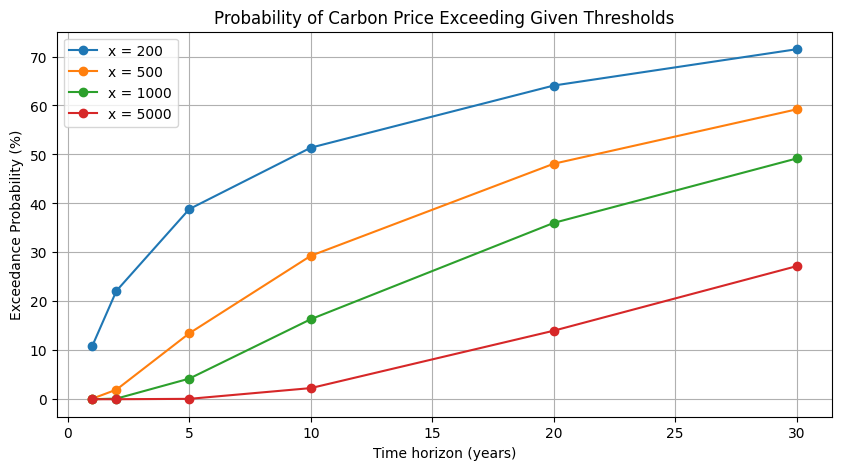

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for GBM
mu = 0.20  # Mean return (drift)
sigma = 0.50  # Volatility (diffusion)
CP0 = 100  # Initial carbon price
t_years = [1, 2, 5, 10, 20, 30]  # Time horizons (years)
n_sim = int(1e6)  # Number of simulations

# Generate GBM paths
np.random.seed(42)

def simulate_gbm(CP0, mu, sigma, T, n_sim):
    """Simulates geometric Brownian motion paths."""
    dt = 1  # Time step in years
    W = np.random.randn(n_sim) * np.sqrt(T)
    return CP0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * W)

# Compute exceedance probabilities
x_vals = [200, 500, 1000, 5000]
exceedance_probs = {x: [] for x in x_vals}

def compute_exceedance_probs(CP0, mu, sigma, x_vals, t_years, n_sim):
    """Computes exceedance probabilities for given thresholds."""
    for T in t_years:
        CP_T = simulate_gbm(CP0, mu, sigma, T, n_sim)
        for x in x_vals:
            exceedance_probs[x].append(np.mean(CP_T >= x) * 100)

compute_exceedance_probs(CP0, mu, sigma, x_vals, t_years, n_sim)

# Plot exceedance probabilities
plt.figure(figsize=(10, 5))
for x in x_vals:
    plt.plot(t_years, exceedance_probs[x], marker='o', label=f"x = {x}")
plt.xlabel("Time horizon (years)")
plt.ylabel("Exceedance Probability (%)")
plt.title("Probability of Carbon Price Exceeding Given Thresholds")
plt.legend()
plt.grid(True)
plt.show()

# Print results in tabular form
import pandas as pd

df_results = pd.DataFrame(exceedance_probs, index=t_years)
df_results.index.name = "Time Horizon (years)"
df_results.columns = [f"Pr(CP(T) ≥ {x}) (%)" for x in x_vals]


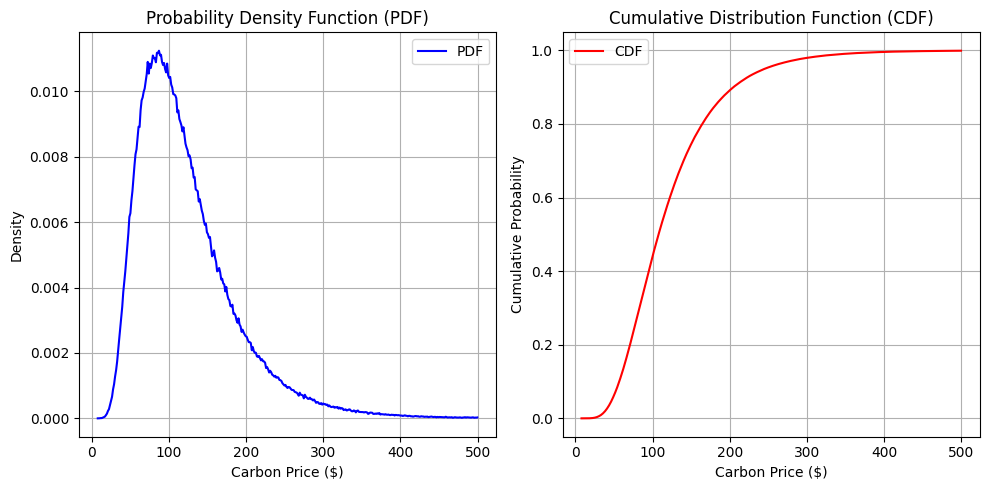

In [2]:
# Compute PDF and CDF for a specific year (e.g., 1 year)
CP_10 = simulate_gbm(CP0, mu, sigma, 1, n_sim)


def make_cdf(x, num_bins=1000):
    """
    Compute the empirical CDF of a given dataset.

    Parameters:
    x (array-like): Input data for which to compute the CDF.
    num_bins (int): Number of bins to use for the CDF estimation.

    Returns:
    x_range (numpy array): Sorted values of x for plotting.
    y (numpy array): Probability density function (PDF) values.
    z (numpy array): Cumulative distribution function (CDF) values.
    """
    # Define range for x
    min_x, max_x = np.min(x), np.max(x)
    x_range = np.linspace(min_x, max_x, num_bins)

    # Compute y: count occurrences in each bin
    y = np.zeros(len(x_range))
    for i in range(len(x_range) - 1):
        y[i+1] = np.sum((x >= x_range[i]) & (x < x_range[i+1]))

    # Normalize y to get a probability distribution
    y = y / np.sum(y)

    # Compute cumulative sum for the CDF
    z = np.zeros(len(y))
    for i in range(1, len(y)):
        z[i] = z[i-1] + y[i]

    return x_range, y, z

x_range, pdf_values, cdf_values = make_cdf(CP_10)


# User-defined range for visualization
price_min = 0  # Adjust as needed
price_max = 500  # Adjust as needed
valid_range = (x_range >= price_min) & (x_range <= price_max)
x_range_filtered = x_range[valid_range]
pdf_values_filtered = pdf_values[valid_range]
cdf_values_filtered = cdf_values[valid_range]

# Plot PDF and CDF
plt.figure(figsize=(10, 5))

# Plot PDF
plt.subplot(1, 2, 1)
plt.plot(x_range_filtered, pdf_values_filtered, label="PDF", color='b')
plt.xlabel("Carbon Price ($)")
plt.ylabel("Density")
plt.title("Probability Density Function (PDF)")
plt.grid(True)
plt.legend()

# Plot CDF
plt.subplot(1, 2, 2)
plt.plot(x_range_filtered, cdf_values_filtered, label="CDF", color='r')
plt.xlabel("Carbon Price ($)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function (CDF)")
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


## Phase 2 Modeling Cash Flow

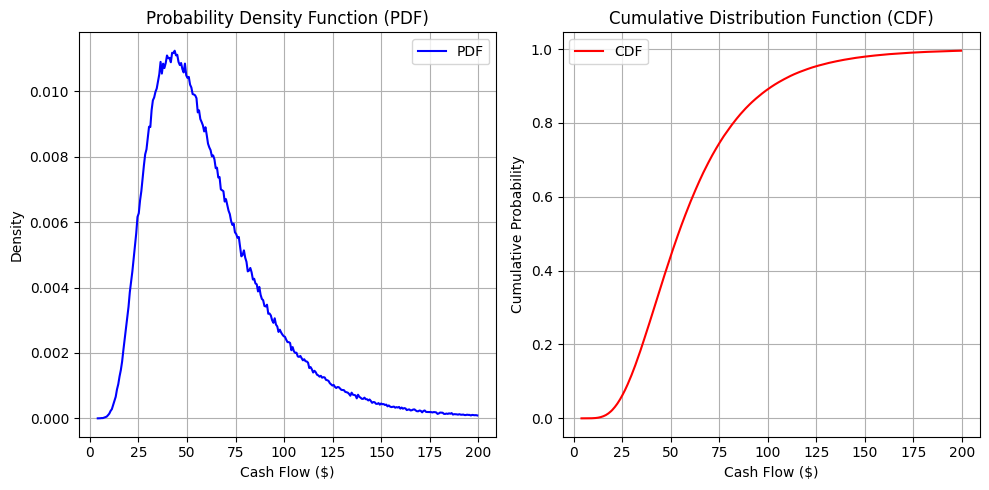

In [15]:
def carbon_costs(carbon_intensity:float, CP:np.array):
    """
    Calculate the cash flow for a given carbon intensity, carbon price, and revenue.

    Parameters:
    carbon_intensity (float): Carbon intensity in tons of CO2 per unit.
    CP (numpy array): Carbon price in dollars per ton of CO2.
    revenue (float): Revenue per unit.

    Returns:
    cash_flow (numpy array): Cash flow for each carbon price.
    """
    carbon_costs = np.zeros(len(CP))
    for i in range(len(CP)):
        carbon_costs[i] = carbon_intensity * CP[i]
    return carbon_costs


# Define parameters
carbon_intensity = 0.5  # tons of CO2 per unit

# Compute cash flow for a given carbon intensity and revenue
carbon_costs_values = carbon_costs(carbon_intensity, CP_10)

# pdf and cdf for cash flow
cc_x_range, cc_pdf_values, cc_cdf_values = make_cdf(carbon_costs_values)

# User-defined range for visualization
price_min = 0  # Adjust as needed
price_max = 200  # Adjust as needed

valid_range = (cc_x_range >= price_min) & (cc_x_range <= price_max)
x_range_filtered = cc_x_range[valid_range]
pdf_values_filtered = cc_pdf_values[valid_range]
cdf_values_filtered = cc_cdf_values[valid_range]

# Plot PDF and CDF
plt.figure(figsize=(10, 5))

# Plot PDF
plt.subplot(1, 2, 1)
plt.plot(x_range_filtered, pdf_values_filtered, label="PDF", color='b')
plt.xlabel("Cash Flow ($)")
plt.ylabel("Density")
plt.title("Probability Density Function (PDF)")
plt.grid(True)
plt.legend()

# Plot CDF
plt.subplot(1, 2, 2)
plt.plot(x_range_filtered, cdf_values_filtered, label="CDF", color='r')
plt.xlabel("Cash Flow ($)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function (CDF)")
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


## Phase 3: Expected Carbon Costs Across Scenarios

\begin{equation}
p = P(CP(T) \leq v_e)
\end{equation}

where $v_e$ is the expected carbon price. We use GBM simulation.

Given the simulated paths, we compute the expect carbon cost $c$ when price is below $v_e$ and $g$ when price is above $v_e$.

In [9]:
E_CP = np.median(CP_10)
p1 = np.mean(CP_10 <= E_CP)
print(p1)
# index min absoulte value 
index1_v = np.argmin(np.abs(x_range - E_CP))
index2_v = np.argmin(np.abs(CP_10 - E_CP))
index1_g = np.argmin(np.abs(cc_x_range - carbon_costs_values[index2_v]))
# # Assuming xg1_range and profitg_cm_pdf are numpy arrays of the same length
Exp_CC = np.trapezoid(cc_pdf_values * cc_x_range)
p1g2 = cc_pdf_values[index1_g]

c = np.trapezoid(cc_x_range[:index1_g] * cc_pdf_values[:index1_g])
g = np.trapezoid(cc_x_range[index1_g:] * cc_pdf_values[index1_g:])
print(c)
print(g)

0.5
18.464004477930896
42.45119095024619


## Phase 4: Pricing and Utility

In [11]:
PM_NShares1=10
N=1*PM_NShares1
b=0.1
P_r_umax = (((1 - p1) / p1) * np.exp(b * N - b * (g - c)) + 1) ** (-1)
print(P_r_umax)

0.8019804784924681


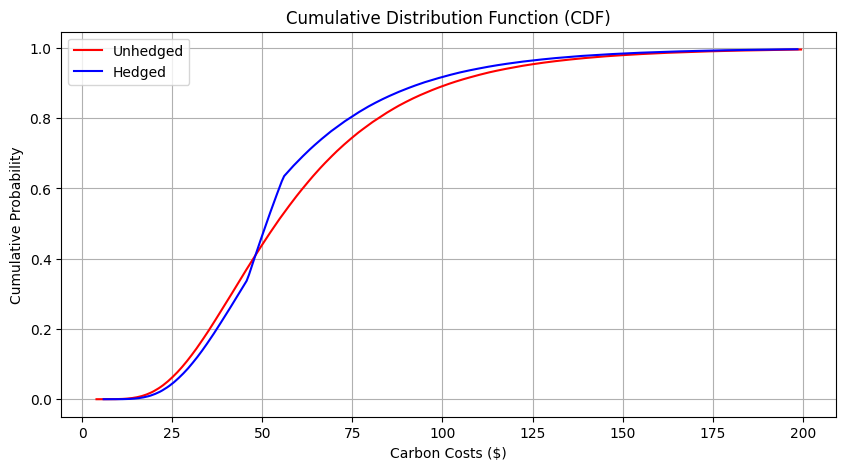

In [16]:
def Payoff_PMw(PM_low, CP):
    """Computes binary prediction market payoff"""
    return np.where(CP < PM_low, 1, 0)


def combined_carbon_costs(
    carbon_intensity: float, CP: np.array, PM_low: float, n: float, PM_price: float):
    """
    Compute the carbon costs including the prediction market payoff.
    """
    carbon_costs = carbon_intensity * CP
    payoff = Payoff_PMw(PM_low, CP)
    return carbon_costs + n * (payoff - PM_price)


combined_carbon_costs_values = combined_carbon_costs(
    carbon_intensity, CP_10, E_CP, PM_NShares1, P_r_umax)

# Compute PDF and CDF for the combined carbon costs
hedged_cc_x_range, hedged_cc_pdf_values, hedged_cc_cdf_values = make_cdf(combined_carbon_costs_values)

# plot cdf hedged and unhedged
plt.figure(figsize=(10, 5))

# Plot CDF unhedged
plt.plot(x_range_filtered, cdf_values_filtered, label="Unhedged", color='r')

# Plot CDF hedged
# filter the range
hedged_x_range_filtered = hedged_cc_x_range[valid_range]
hedged_cdf_values_filtered = hedged_cc_cdf_values[valid_range]


plt.plot(hedged_x_range_filtered, hedged_cdf_values_filtered, label="Hedged", color='b')

plt.xlabel("Carbon Costs ($)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function (CDF)")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

